### Dataset:
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [1]:
# Kaggle instalaltion in Colab # https://www.kaggle.com/general/74235
!pip install kaggle


In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
     |████████████████████████████████| 3.3MB 37.2MB/s 


In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Initialize and Authenticate Kaggle API
#from kaggle.api.kaggle_api_extended import kaggleApi 
#api = kaggleApi()
#api.authenticate()


In [5]:
!kaggle competitions download -c 'sentiment-analysis-on-movie-reviews'

  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 86.4MB/s]
  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 68.6MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 82.7MB/s]


In [6]:
!mkdir input
!unzip train.tsv.zip -d input
!unzip test.tsv.zip -d input

Archive:  train.tsv.zip
  inflating: input/train.tsv         
Archive:  test.tsv.zip
  inflating: input/test.tsv          


## Preprocessing Dataset

In [7]:
import pandas as pd
train_df = pd.read_csv('input/train.tsv', sep='\t')
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

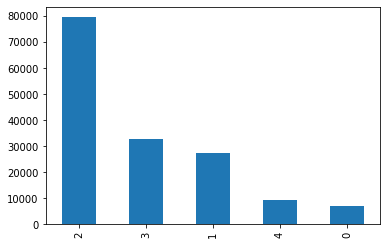

In [8]:
train_df['Sentiment'].value_counts().plot(kind='bar')

In [9]:
seq_len = 512
num_samples = len(train_df)

num_samples, seq_len

(156060, 512)

In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
tokens = tokenizer(train_df['Phrase'].tolist(), 
                   max_length=seq_len,
                   truncation=True,
                   padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np'
                   )

In [13]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [15]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [16]:
# Save these tokens as Numpy Binary Files
import numpy as np
with open('movie-xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

In [17]:
arr = train_df['Sentiment'].values
arr.shape

(156060,)

In [18]:
# One-hot encode the lables
labels = np.zeros((num_samples, arr.max()+1))
labels[np.arange(num_samples), arr] = 1
labels.shape

(156060, 5)

In [19]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f, labels)

# Building Dataset

In [20]:
import numpy as np

In [21]:
with open('movie-xids.npy', 'rb') as f:
  Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
  Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
  labels = np.load(f, allow_pickle=True)

In [24]:
Xids.shape, Xmask.shape, labels.shape

((156060, 512), (156060, 512), (156060, 5))

In [25]:
import tensorflow as tf


In [26]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [27]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [ ]:
(input_ids, attention_mask), outputs

In [28]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks}, labels

In [29]:
dataset = dataset.map(map_func)

In [30]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [32]:
batch_size = 16

In [33]:
# Dataset Shuffle, Batch, Split, and Save
dataset = dataset.shuffle(100000).batch(batch_size, drop_remainder=True)

In [34]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [35]:
split = 0.9
size = Xids.shape[0]
size = int((Xids.shape[0] / batch_size) * split)

In [36]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [37]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [69]:
train_ds.element_spec == val_ds.element_spec

True

In [52]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [39]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [40]:
from transformers import TFAutoModel

In [41]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [42]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [43]:
import tensorflow as tf

In [44]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask) [1]

# classification head
x = tf.keras.layers.Dense(1024, activation='relu') (embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs') (x)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [45]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [46]:
model.layers[2].trainable = False

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [75]:
element_spec = ({'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                  'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                  tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [53]:
val_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [76]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [77]:
train_ds.take(1)

<TakeDataset shapes: ({attention_mask: (16, 512), input_ids: (16, 512)}, (16, 5)), types: ({attention_mask: tf.int64, input_ids: tf.int64}, tf.float64)>

>> Always check the element_spec

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
6639/8778 [=====================>........] - ETA: 13:52 - loss: 1.1288 - accuracy: 0.5471

In [ ]:
model.save('sentiment_model')